# GPT-2 Classifier (no pretraining)

In this notebook we will train a GPT-2 classifier from scratch for the proxy task.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import GPT2Model, GPT2DoubleHeadsModel, GPT2Config
import eval_models
from train_utils import *

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.59
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
torch.cuda.set_device(0)

### Prep databunch

In [5]:
bs = 64
seed = 42
tok_model_dir = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_target'
max_seq_len = 512

In [6]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [7]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')
cls_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('</s>')

In [8]:
bpe_path = Path('/home/tjtsai/.fastai/data/bscore_lm/bpe_data')
train_df = pd.read_csv(bpe_path/'train64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid64.char.csv')
test_df = pd.read_csv(bpe_path/'test64.char.csv')

In [9]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

### Train Classifier

In [10]:
model_class, config_class = GPT2Model, GPT2Config

In [11]:
lang_model_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/models/gpt2_train-target_lm'
config = config_class.from_pretrained(lang_model_path)
config.num_labels = data_clas.c

In [12]:
transformer_model = model_class(config)
gpt2_clas = GPT2Classifier(transformer_model, config, pad_idx, cls_idx)

In [ ]:
# learner.destroy()
# torch.cuda.empty_cache()

In [13]:
learner = Learner(data_clas, gpt2_clas, metrics=[accuracy, FBeta(average = 'macro', beta=1)])

In [14]:
list_layers = [learner.model.transformer.wte, 
               learner.model.transformer.wpe, 
               learner.model.transformer.h[0],
               learner.model.transformer.h[1],
               learner.model.transformer.h[2],
               learner.model.transformer.h[3],
               learner.model.transformer.h[4],
               learner.model.transformer.h[5],
               learner.model.transformer.ln_f]

In [15]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30000, 768)
), Sequential(
  (0): Embedding(514, 768)
  (1): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1D()
  (7): Conv1D()
  (8): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1D()
  (7): Conv1D()
  (8): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1

In [16]:
seed_all(seed)

In [17]:
learner.unfreeze()

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-05


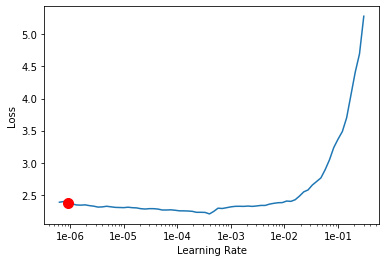

In [19]:
learner.recorder.plot(suggestion=True)

In [20]:
lr = 1e-5

In [21]:
learner.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.833041,1.929880,0.293704,0.264085,02:06
1,1.379003,1.961380,0.351389,0.327018,02:07
2,1.039239,2.080066,0.350370,0.336979,02:08
3,0.914094,2.104732,0.358889,0.343324,02:07


In [22]:
learner.save('gpt2_clas')
#learner.load('gpt2_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [23]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [24]:
learner.validate(data_clas_test.valid_dl)

[2.0445936, tensor(0.3733), tensor(0.3578)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [25]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

In [26]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [27]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.48849692940711975, 0.49233129620552063),
 (0.41876627013515755, 0.37586842460305125))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [28]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

In [29]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [30]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.4578220844268799, 0.4892638027667999),
 (0.41091742266393083, 0.3832075378019597))

### Error Analysis

In [31]:
interp = ClassificationInterpretation.from_learner(learner)

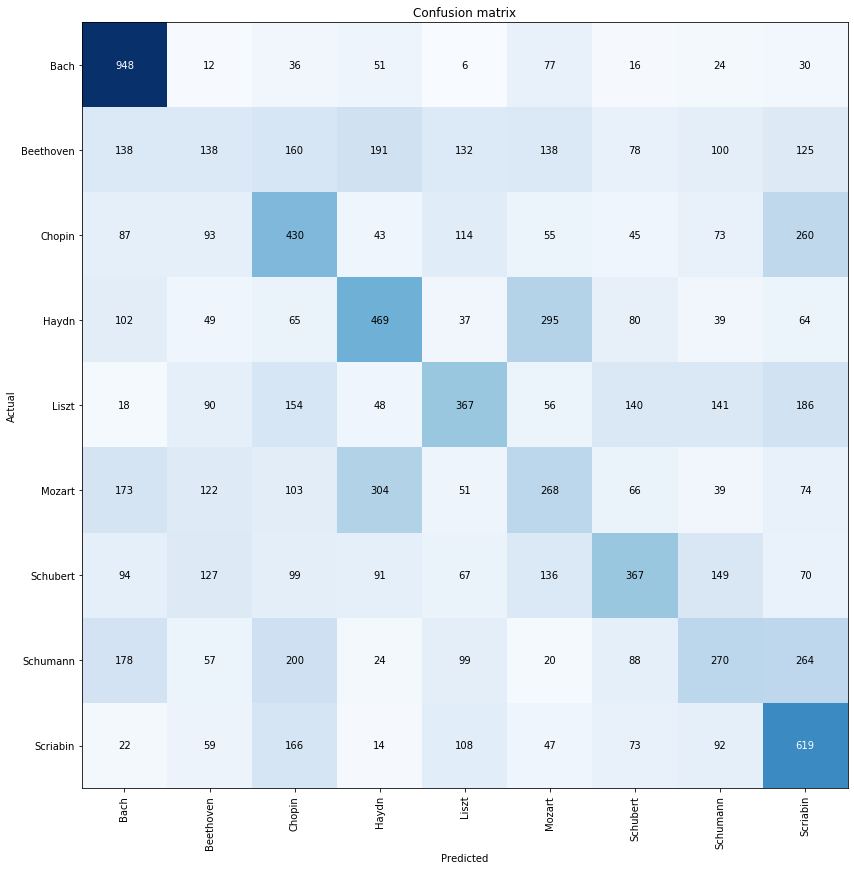

In [32]:
interp.plot_confusion_matrix(figsize=(12,12))